# Freeway

- The player begins at the bottom of the screen and motion is restricted to traveling up and down. 
- Player speed is also restricted such that the player can only move every 3 frames. 
- A reward of +1 is given when the player reaches the top of the screen, at which point the player is returned to the bottom. 
- Cars travel horizontally on the screen and teleport to the other side when the edge is reached.
- When hit by a car, the player is returned to the bottom of the screen. 
- Car direction and speed is indicated by 5 trail channels, the location of the trail gives direction 
- while the specific channel indicates how frequently the car moves (from once every frame to once every 5 frames). 
- Each time the player successfully reaches the top of the screen, the car speeds are randomized. 
- Termination occurs after 2500 frames have elapsed.

In [1]:
import os

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import Image, display

from dreamerv2.models.rssm import RSSMDiscState
from dreamerv2.training.config import MinAtarConfig
from dreamerv2.training.evaluator import Evaluator
from dreamerv2.utils.wrapper import GymMinAtar, OneHotAction, freewayPOMDP

env_name = "freeway"
exp_id = "0_pomdp"
device = "cuda:0"

ACTIONS = {
    0: "STAY",
    1: "UP",
    2: "DOWN",
}


def render_freeway(obs):
    buf = np.zeros((10, 10, 3), dtype=np.uint8)
    buf[obs[0]] = (255, 255, 255)
    buf[obs[1]] = (255, 0, 0)
    return buf

## Always UP

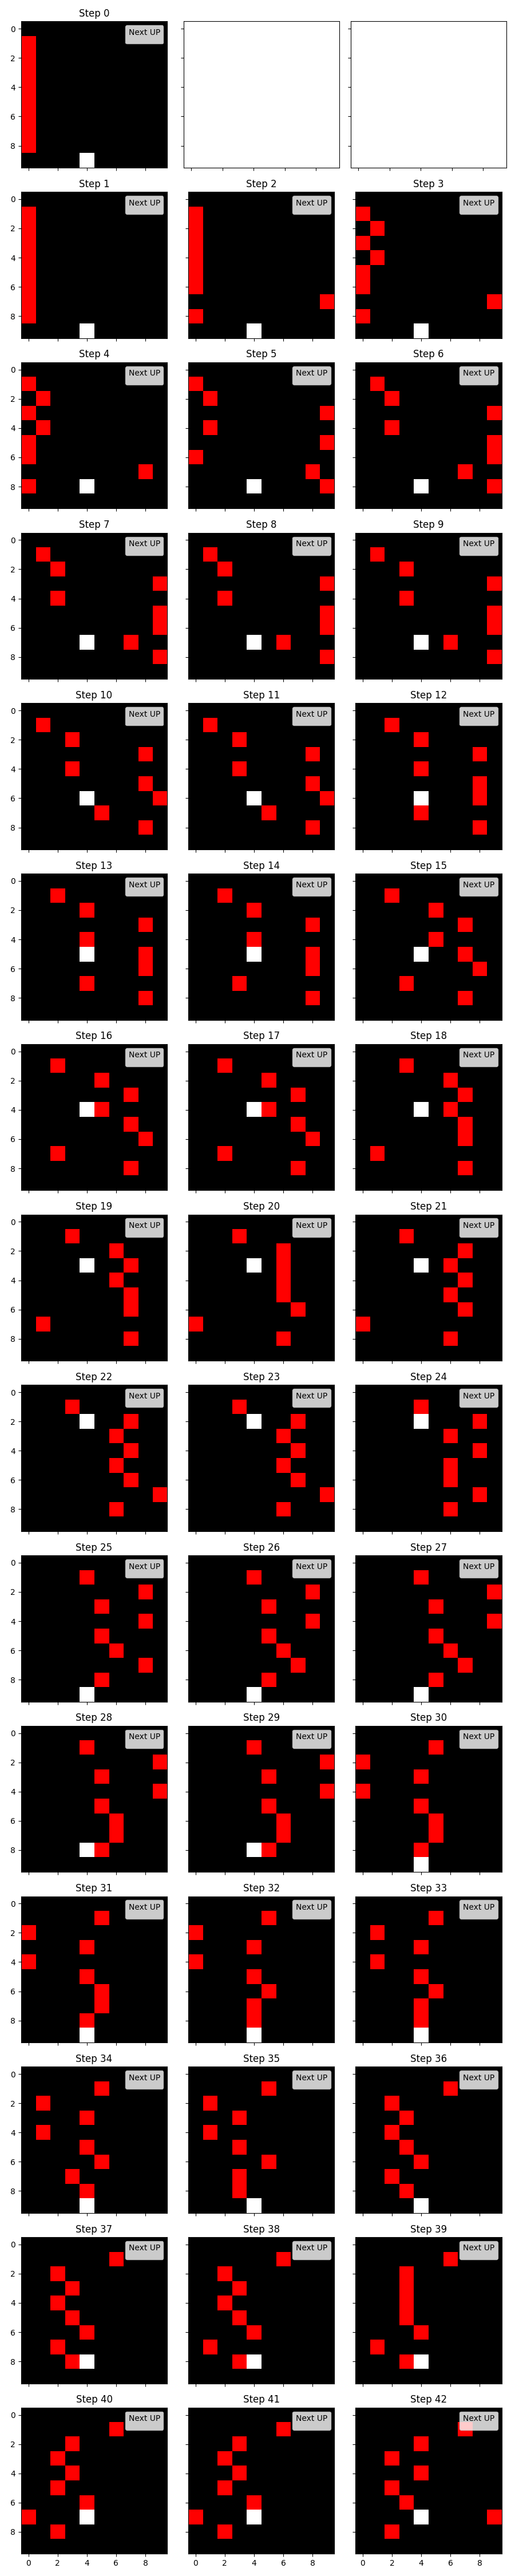

In [2]:
# Produce always same episode, disable sticky actions
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
env.env.env.env.sticky_action_prob = 0
env.env.env.seed(42)

obs = env.reset()
action_up = np.array([0, 1, 0])

fig, axs = plt.subplots(15, 3, figsize=(9, 45), sharex=True, sharey=True)
axs = [axs[0, 0]] + axs[1:, :].flatten().tolist()

for t, ax in enumerate(axs):
    ax.imshow(render_freeway(obs))
    ax.legend([], loc="upper right", title=f"Next UP")
    ax.set_title(f"Step {t}")

    obs, reward, done, info = env.step(action_up)

fig.tight_layout()
fig.savefig("freeway_up.png")
plt.close(fig)
display(Image("freeway_up.png", width=700))

## Learned policy (single rollout)

In [3]:
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
result_dir = os.path.join("../results_official", f"{env_name}_{exp_id}")
model_dir = os.path.join(result_dir, "models")
f = "models_best.pth"

config = MinAtarConfig(
    env=env_name,
    obs_shape=env.observation_space.shape,
    action_size=env.action_space.shape[0],
    obs_dtype=bool,
    action_dtype=np.float32,
    model_dir=model_dir,
    eval_episode=10,
    eval_render=False,
)

evaluator = Evaluator(config, device)
evaluator.load_model(evaluator.config, os.path.join(model_dir, f))

Important methods for inference:

`evaluator.RSSM.rssm_observe`

```python
def rssm_observe(self, obs_embed, prev_action, prev_nonterm, prev_rssm_state):
    # Without looking at the current observation, use the previous state and action
    # to predict the current state. From this, only use the deterministic part.
    prior_rssm_state = self.rssm_imagine(prev_action, prev_rssm_state, prev_nonterm)
    deter_state = prior_rssm_state.deter
    
    # Using the encoding of the current observation and the deterministic state obtained without 
    # looking at the observation, compute the logits of the stochastic state and
    # sample 
    x = torch.cat([deter_state, obs_embed], dim=-1)
    posterior_logit = self.fc_posterior(x)
    posterior_stoch_state = self.get_stoch_state({'logit':posterior_logit})
    
    posterior_rssm_state = RSSMDiscState(posterior_logit, posterior_stoch_state, deter_state)
    return prior_rssm_state, posterior_rssm_state
```

`evaluator.RSSM.rssm_imagine`
```python
def rssm_imagine(self, prev_action, prev_rssm_state, nonterms=True):
    # Without looking at the current observation, use the previous state and action
    # to predict (imagine) the current state.
    state_action_embed = self.fc_embed_state_action(torch.cat([prev_rssm_state.stoch*nonterms, prev_action],dim=-1))
    deter_state = self.rnn(state_action_embed, prev_rssm_state.deter*nonterms)
    prior_logit = self.fc_prior(deter_state)
    prior_stoch_state = self.get_stoch_state({'logit':prior_logit})
    prior_rssm_state = RSSMDiscState(prior_logit, prior_stoch_state, deter_state)
```

`evaluator.RSSM.get_stoch_state`
```python
def get_stoch_state(self, stats):
    logit = stats['logit']
    logit = torch.reshape(logit, shape = (*logit.shape[:-1], self.category_size, self.class_size))
    
    # Straight-through gradients
    dist = torch.distributions.OneHotCategorical(logits=logit)        
    stoch = dist.sample() + dist.probs - dist.probs.detach()
    
    return torch.flatten(stoch, start_dim=-2, end_dim=-1)
```

`evaluator.ActionModel.forward`
```python
def forward(self, model_state):
    logits = self.model(model_state)
    
    # Straight-through gradients
    action_dist = torch.distributions.OneHotCategorical(logits=logits)
    action = action_dist.sample()
    action = action + action_dist.probs - action_dist.probs.detach()
    
    return action, action_dist
```

In [4]:
score = 0
done = False
history = []
torch.set_grad_enabled(False)

# Produce always same episode
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
env.env.env.seed(12)
torch.manual_seed(13)

# [2, 10, 10]
obs = env.reset()

# Initial RSSM state (all zeros):
# state.deter [1, 200]
# state.logit [1, 400] (20 categegoricals, 20 classes each)
# state.stoch [1, 400] (20 one-hot samples, sampled from logit)
prev_rssm_state = evaluator.RSSM._init_rssm_state(batch_size=1)

# [1, 3]
prev_action = torch.zeros(1, evaluator.action_size).to(evaluator.device)

for _ in range(50):
    # Embed observation, [1, 200]
    embed = evaluator.ObsEncoder(
        torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(evaluator.device)
    )

    # During evaluation, use the posterior state, i.e. the one obtained using the current observation.
    _, posterior_rssm_state = evaluator.RSSM.rssm_observe(
        embed, prev_action, not done, prev_rssm_state
    )

    # Concat deter+stoch state [1, 600]
    model_state = evaluator.RSSM.get_model_state(posterior_rssm_state)

    # The history consists of:
    # current obs         o_t
    # current state       h_t, s_t
    # predicted action    a_t
    # internal move timer (will the action actually have effect?)
    action, _ = evaluator.ActionModel(model_state)
    history.append(
        (
            obs,
            RSSMDiscState(
                posterior_rssm_state.logit.cpu().squeeze(0).reshape(20, 20),
                posterior_rssm_state.stoch.cpu().squeeze(0).reshape(20, 20),
                posterior_rssm_state.deter.cpu().squeeze(0),
            ),
            action.squeeze(0).cpu().numpy(),
            env.env.env.env.env.move_timer == 0,
        )
    )

    obs, reward, done, _ = env.step(action.squeeze(0).cpu().numpy())
    score += reward
    prev_rssm_state = posterior_rssm_state
    prev_action = action

score, len(history)

(1, 50)

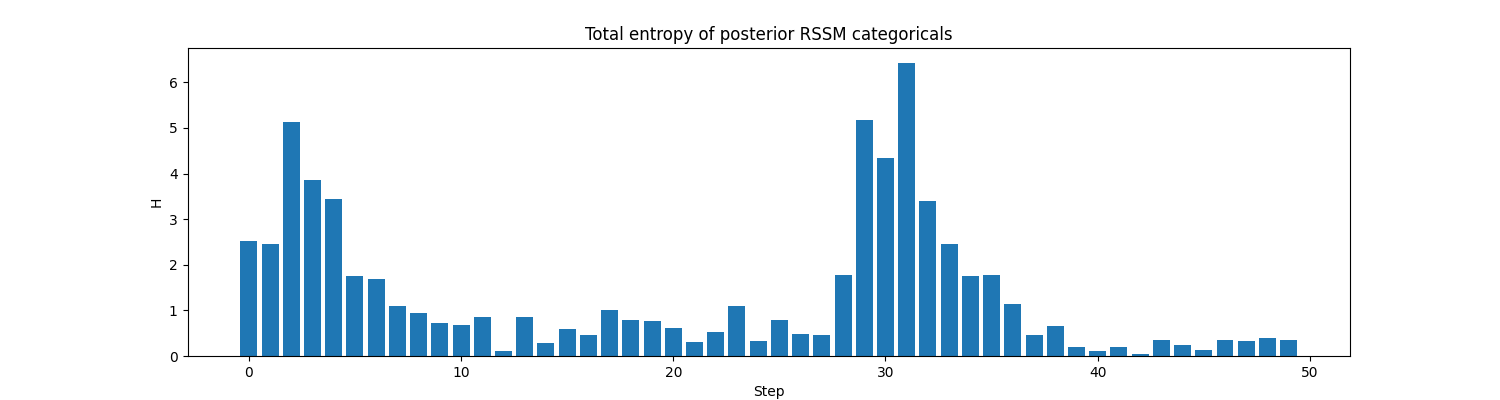

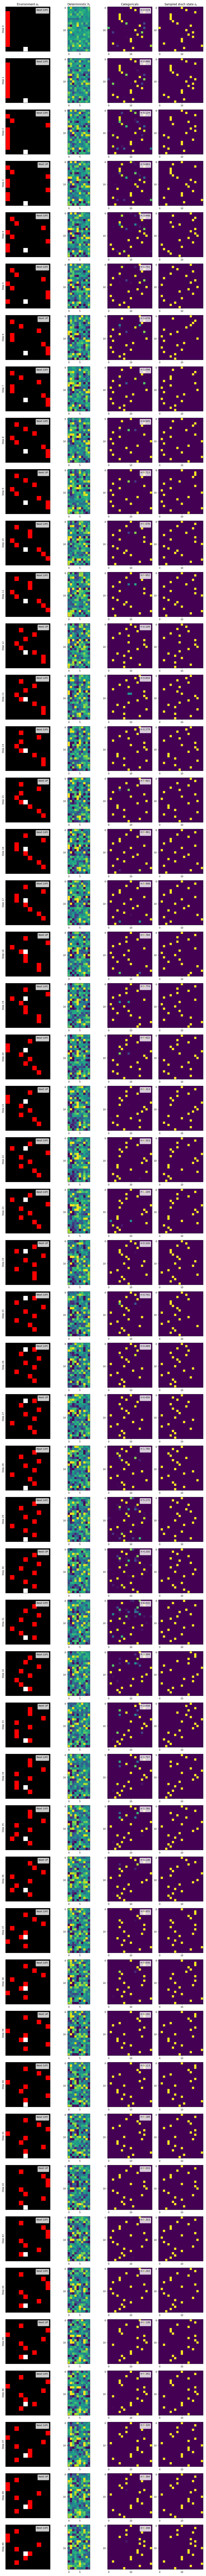

In [5]:
def render_freeway(obs):
    buf = np.zeros((10, 10, 3), dtype=np.uint8)
    buf[obs[0]] = (255, 255, 255)
    buf[obs[1]] = (255, 0, 0)
    return buf


fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.bar(
    np.arange(len(history)),
    [
        torch.distributions.Categorical(logits=posterior_rssm_state.logit)
        .entropy()
        .sum()
        .item()
        for _, posterior_rssm_state, _, _ in history
    ],
)
ax.set_title("Total entropy of posterior RSSM categoricals")
ax.set_xlabel("Step")
ax.set_ylabel("H")
fig.savefig("freeway_entropy.png")
plt.close(fig)
display(Image("freeway_entropy.png"))

fig, axs = plt.subplots(len(history), 4, figsize=(12, 3 * len(history)))
axs[0, 0].set_title("Environment $o_t$")
axs[0, 1].set_title("Deterministic $h_t$")
axs[0, 2].set_title("Categoricals")
axs[0, 3].set_title("Sampled stoch state $s_t$")

for t, axs_row in enumerate(axs):
    obs, posterior_rssm_state, action, has_effect = history[t]

    ax = axs_row[0]
    ax.imshow(render_freeway(obs))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Step {t}")
    ax.legend(
        [],
        loc="upper right",
        title=(
            # If the action is in () it means that it will
            # actually have no effect due to the game timer.
            f"Next {ACTIONS[action.argmax()]}"
            if has_effect
            else f"Next ({ACTIONS[action.argmax()]})"
        ),
    )

    ax = axs_row[1]
    ax.imshow(posterior_rssm_state.deter.reshape(20, 10).numpy())
    ax.set_xticks([0, 5])
    ax.set_yticks([0, 10])

    ax = axs_row[2]
    ax.imshow(posterior_rssm_state.logit.softmax(-1).numpy(), vmin=0, vmax=1)
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    e = (
        torch.distributions.Categorical(logits=posterior_rssm_state.logit)
        .entropy()
        .sum()
        .item()
    )
    ax.legend([], loc="upper right", title=f"H {e:.3f}")

    ax = axs_row[3]
    ax.imshow(posterior_rssm_state.stoch.numpy(), vmin=0, vmax=1)
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])

fig.tight_layout()
fig.savefig("freeway_states.png")
plt.close(fig)
display(Image("freeway_states.png", width=1000))

## Multiple rollouts

In [6]:
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
result_dir = os.path.join("../results_official", f"{env_name}_{exp_id}")
model_dir = os.path.join(result_dir, "models")
f = "models_best.pth"

config = MinAtarConfig(
    env=env_name,
    obs_shape=env.observation_space.shape,
    action_size=env.action_space.shape[0],
    obs_dtype=bool,
    action_dtype=np.float32,
    model_dir=model_dir,
    eval_episode=10,
    eval_render=False,
)

evaluator = Evaluator(config, device)
evaluator.load_model(evaluator.config, os.path.join(model_dir, f))

In [7]:
histories = []
torch.set_grad_enabled(False)

for episode_idx in range(200):
    env.env.env.seed(episode_idx)
    torch.manual_seed(episode_idx)
    done = False
    history = []
    histories.append(history)

    obs = env.reset()
    prev_rssm_state = evaluator.RSSM._init_rssm_state(batch_size=1)
    prev_action = torch.zeros(1, evaluator.action_size).to(evaluator.device)

    for _ in range(50):
        embed = evaluator.ObsEncoder(
            torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(evaluator.device)
        )
        _, posterior_rssm_state = evaluator.RSSM.rssm_observe(
            embed, prev_action, not done, prev_rssm_state
        )
        model_state = evaluator.RSSM.get_model_state(posterior_rssm_state)
        action, _ = evaluator.ActionModel(model_state)

        history.append(
            (
                obs,
                RSSMDiscState(
                    posterior_rssm_state.logit.cpu().squeeze(0).reshape(20, 20),
                    posterior_rssm_state.stoch.cpu().squeeze(0).reshape(20, 20),
                    posterior_rssm_state.deter.cpu().squeeze(0),
                ),
                action.squeeze(0).cpu().numpy(),
                env.env.env.env.env.move_timer == 0,
            )
        )

        obs, reward, done, _ = env.step(action.squeeze(0).cpu().numpy())
        prev_rssm_state = posterior_rssm_state
        prev_action = action

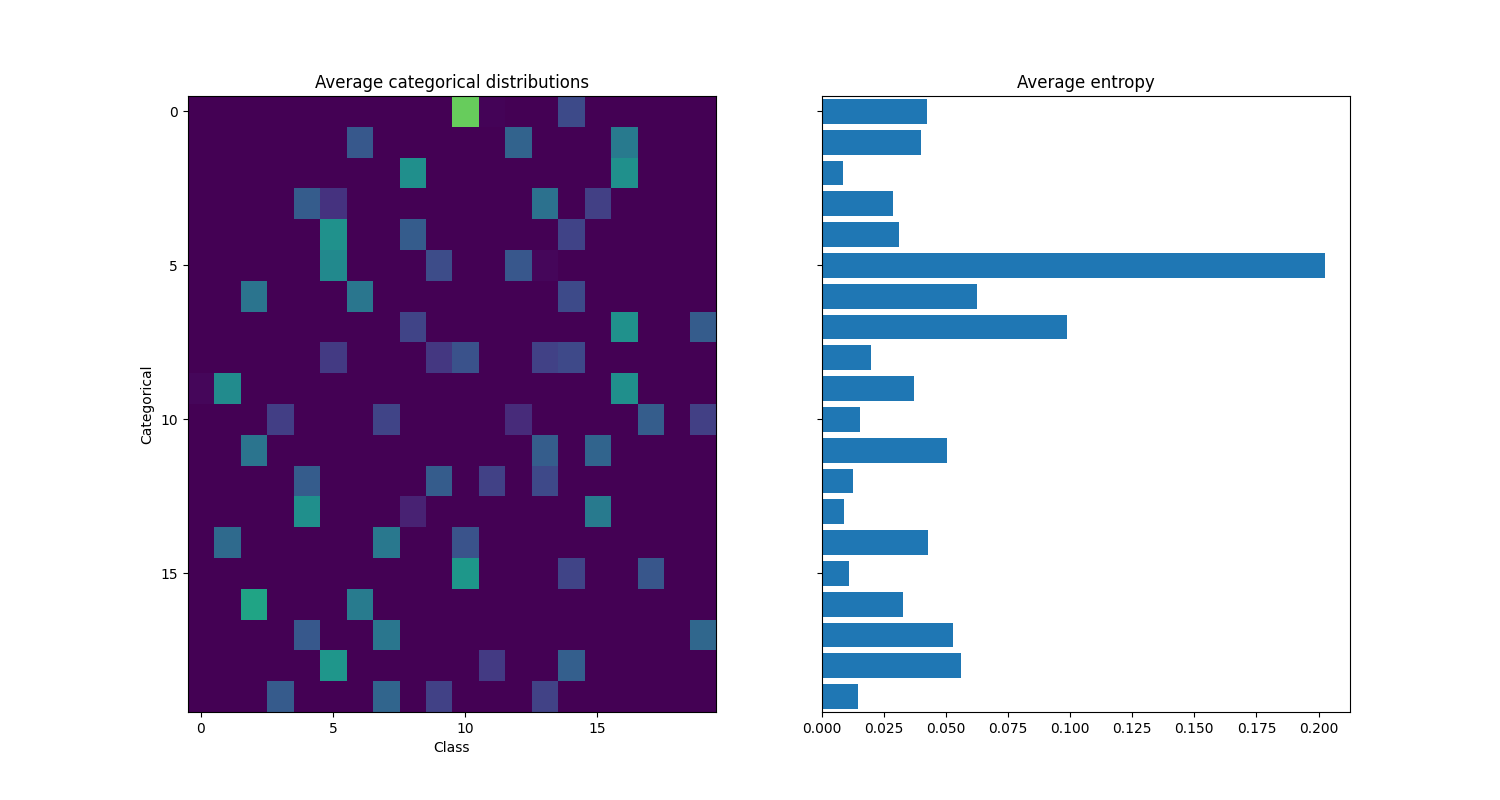

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

logits = torch.stack(
    [
        torch.stack(
            [posterior_rssm_state.logit for _, posterior_rssm_state, *_ in history]
        )
        for history in histories
    ]
)

ax = axs[0]
ax.imshow(
    logits.softmax(dim=-1).mean(dim=[0, 1]).numpy(), vmin=0, vmax=1, aspect="auto"
)
ax.set_title("Average categorical distributions")
ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 5, 10, 15])
ax.set_xlabel("Class")
ax.set_ylabel("Categorical")

ax = axs[1]
ax.barh(
    np.arange(20),
    torch.distributions.Categorical(logits=logits).entropy().mean(dim=[0, 1]).numpy(),
)
ax.set_yticks([0, 5, 10, 15])
ax.set_title("Average entropy")

fig.savefig("freeway_categoricals.png")
plt.close(fig)
display(Image("freeway_categoricals.png", width=1000))

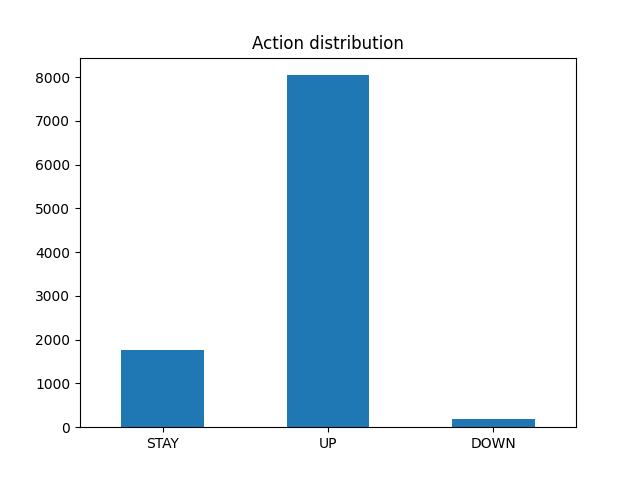

In [9]:
fig, ax = plt.subplots(1, 1)
(
    pd.Series([action.argmax() for history in histories for _, _, action, _ in history])
    .value_counts()
    .sort_index()
    .rename(index=ACTIONS)
    .plot.bar(ax=ax, rot=0, title="Action distribution")
)

fig.savefig("freeway_actions.png")
plt.close(fig)
display(Image("freeway_actions.png", width=400))